In [32]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [3]:
batch_size = 512

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([512, 1, 28, 28])
Shape of y: torch.Size([512]) torch.int64


In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        img_width = 28
        img_height = 28

        hidden_layer_1_nodes = 512
        hidden_layer_2_nodes = 512

        output_nodes = 10

        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(img_height * img_width, hidden_layer_1_nodes),
            nn.ReLU(),
            nn.Linear(hidden_layer_1_nodes, hidden_layer_2_nodes),
            nn.ReLU(),
            nn.Linear(hidden_layer_2_nodes, output_nodes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.084876  [  512/60000]
loss: 2.047958  [51712/60000]
Test Error: 
 Accuracy: 55.2%, Avg loss: 2.048053 

Epoch 2
-------------------------------
loss: 2.053516  [  512/60000]
loss: 2.013108  [51712/60000]
Test Error: 
 Accuracy: 57.8%, Avg loss: 2.012909 

Epoch 3
-------------------------------
loss: 2.019107  [  512/60000]
loss: 1.975256  [51712/60000]
Test Error: 
 Accuracy: 59.0%, Avg loss: 1.974600 

Epoch 4
-------------------------------
loss: 1.981541  [  512/60000]
loss: 1.934431  [51712/60000]
Test Error: 
 Accuracy: 59.8%, Avg loss: 1.933219 

Epoch 5
-------------------------------
loss: 1.940953  [  512/60000]
loss: 1.890855  [51712/60000]
Test Error: 
 Accuracy: 60.2%, Avg loss: 1.889054 

Epoch 6
-------------------------------
loss: 1.897607  [  512/60000]
loss: 1.844962  [51712/60000]
Test Error: 
 Accuracy: 60.5%, Avg loss: 1.842593 

Epoch 7
-------------------------------
loss: 1.851946  [  512/60000]
loss: 1.797427  [5

In [12]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [14]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

Predicted: "Ankle boot", Actual: "Ankle boot"


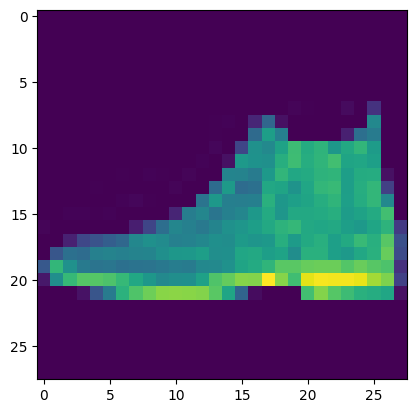

In [33]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

plt.imshow(test_data[0][0][0])

In [86]:
weights = [w.weight.data[0].cpu() for w in model.modules() if isinstance(w, nn.Linear)]


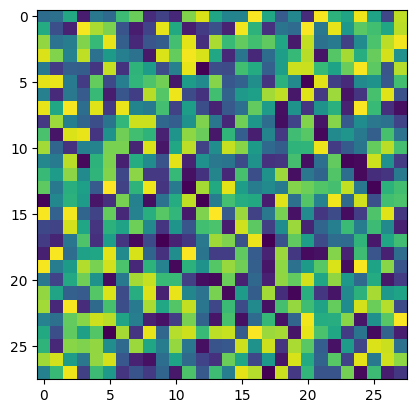

In [87]:
plt.imshow(torch.reshape(weights[0], (28,28)))

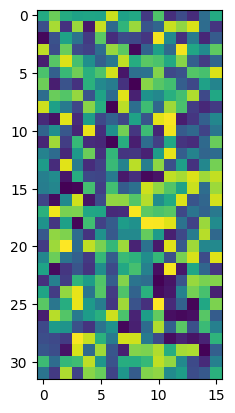

In [93]:
plt.imshow(torch.reshape(weights[1], (32,16)))

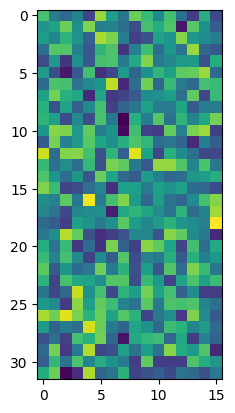

In [100]:
plt.imshow(torch.reshape(weights[2], (32,16)))